Step 1 — Imports, seeds, helpers

In [1]:
#!pip install tensorflow

In [2]:
#!pip install scikit-learn

In [3]:
# Standard libraries
import os, random                                      # for OS utilities and reproducibility helpers
import numpy as np                                     # for numerical arrays

# TensorFlow / Keras core
import tensorflow as tf                                # main DL framework

# Keras layers & utilities you'll use
from tensorflow.keras.layers import (Input, SeparableConv2D, DepthwiseConv2D, BatchNormalization,
                                     Activation, AveragePooling2D, Dropout, Dense, Add, Lambda,
                                     GlobalAveragePooling2D, GlobalAveragePooling1D,
                                     MultiHeadAttention, Reshape, LayerNormalization, Conv2D)
from tensorflow.keras.models import Model              # for building functional models
from tensorflow.keras.optimizers import Adam           # optimizer
from tensorflow.keras.losses import BinaryCrossentropy # binary classification loss
from tensorflow.keras.metrics import Accuracy          # accuracy metric
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # callbacks
from tensorflow.keras import backend as K              # Keras backend for shape introspection

# Scikit-learn utilities
from sklearn.model_selection import StratifiedKFold    # stratified k-fold CV
from sklearn.metrics import (confusion_matrix,         # confusion matrix
                             precision_score, recall_score,
                             f1_score, accuracy_score) # metrics

# Plotting
import matplotlib.pyplot as plt                        # for charts

# Reproducibility
SEED = 42                                              # fixed seed value
np.random.seed(SEED)                                   # seed numpy RNG
tf.random.set_seed(SEED)                               # seed TF RNG
random.seed(SEED)                                      # seed python RNG

# Nice-to-have: enable memory growth if a GPU is present (prevents TF from grabbing all VRAM)
gpus = tf.config.list_physical_devices('GPU')          # list available GPUs
print("TensorFlow:", tf.__version__)                   # show TF version
print("GPUs:", gpus)                                   # show detected GPUs
if gpus:                                               # if at least one GPU exists
    for g in gpus:                                     # iterate over GPUs
        try:
            tf.config.experimental.set_memory_growth(g, True)  # enable growth
        except Exception as e:
            print("GPU memory growth not set:", e)     # print warning if it fails


TensorFlow: 2.20.0
GPUs: []


Step 2: Load the arrays

In [4]:
# Define Windows paths exactly as you provided (raw strings to avoid escaping issues)
eeg_path = r"C:\Self Learning\Research Papers\UOW Research Papers\eSport Players with EEG Data\EEG Data\final eeg data\final_eeg.npy"
labels_path = r"C:\Self Learning\Research Papers\UOW Research Papers\eSport Players with EEG Data\EEG Data\final eeg data\final_eeg_labels.npy"

print("Loading EEG data from disk...")                  # status print
X = np.load(eeg_path)                                   # load EEG array, expected shape (N, 14, 200)
y = np.load(labels_path)                                # load labels, expected shape (N,) or (N,1)
print("Loaded.")                                        # confirm load
print("Raw X shape:", X.shape, "| dtype:", X.dtype)     # show EEG array shape/dtype
print("Raw y shape:", y.shape, "| dtype:", y.dtype)     # show label array shape/dtype

y = np.squeeze(y).astype(int)                           # ensure labels are 1D ints
print("y squeezed shape:", y.shape, "| unique:", np.unique(y))  # show label distribution

assert X.ndim == 3, f"Expected X to be (N,14,200). Got {X.shape}"             # sanity check dims
assert X.shape[1] == 14 and X.shape[2] == 200, "Expected 14 electrodes & 200 samples."  # shape check
assert set(np.unique(y)).issubset({0,1}), "Labels must be {0,1}."             # binary check

X = X[..., np.newaxis]                                   # add channel dim -> (N, 14, 200, 1)
print("X after adding channel dim:", X.shape)            # verify new shape


Loading EEG data from disk...
Loaded.
Raw X shape: (4770, 14, 200) | dtype: float32
Raw y shape: (4770,) | dtype: int64
y squeezed shape: (4770,) | unique: [0 1]
X after adding channel dim: (4770, 14, 200, 1)


Step 3: Prepare 5-fold CV

In [5]:
# Configure cross-validation settings
N_SPLITS = 5                                             # 5-fold CV as requested
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)  # stratified split preserves class ratios

print("Prepared StratifiedKFold with", N_SPLITS, "splits.")  # status print
print("Total samples:", X.shape[0])                           # show dataset size


Prepared StratifiedKFold with 5 splits.
Total samples: 4770


Step 4: Define AFNet

In [6]:
def SpatialAttention(x):
    """
    Implements a spatial attention mechanism to focus on the most relevant EEG electrodes.
    NOTE: uses Keras layers only (Reshape/Multiply) to avoid KerasTensor issues.
    """
    num_electrodes = K.int_shape(x)[1]                   # get static electrode count (should be 14)
    attn = GlobalAveragePooling2D()(x)                   # global pooling across spatial/time -> (batch, channels)
    attn = Dense(64, activation='relu')(attn)            # learn intermediate attention representation
    attn = Dense(num_electrodes, activation='sigmoid')(attn)  # per-electrode weights in [0,1], shape (batch, 14)
    attn = Reshape((num_electrodes, 1, 1))(attn)         # reshape to broadcast over (14, time, channels)
    x = tf.keras.layers.Multiply()([x, attn])            # apply attention via element-wise multiplication (broadcast)
    return x                                             # return attended feature maps

def TransformerBlock(x, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1):
    """
    Implements a Transformer encoder block with MHA + FFN and residual connections.
    Input shape expected: (batch, seq_len, embed_dim)
    """
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)  # self-attention
    attn_out = Dropout(dropout_rate)(attn_out)                                  # dropout after MHA
    x = Add()([x, attn_out])                                                    # residual add
    x = LayerNormalization()(x)                                                 # layer norm

    ff = Dense(ff_dim, activation='relu')(x)                                    # feed-forward expansion
    ff = Dropout(dropout_rate)(ff)                                              # dropout in FFN
    ff = Dense(x.shape[-1])(ff)                                                 # project back to embed_dim
    x = Add()([x, ff])                                                          # residual add
    x = LayerNormalization()(x)                                                 # layer norm
    return x                                                                    # return block output

def EEGNet_SpatialTransformer(input_shape=(14, 200, 1), dropout_rate=0.5, num_heads=4, ff_dim=128):
    """
    Your AFNet, with only shape-related adjustments:
    - input_shape set to (14, 200, 1)
    - spatial DepthwiseConv2D kernel changed from (61,1) to (14,1)
    - safe Keras ops in SpatialAttention
    - minimal tiling to align shapes for residual addition
    """
    print("Building model with input_shape:", input_shape)                      # trace construction
    inputs = Input(shape=input_shape)                                           # input tensor

    # Depthwise Separable Convolution with Shared Filters (temporal kernels)
    x = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)     # conv features
    x = BatchNormalization()(x)                                                 # normalize
    x = Activation('relu')(x)                                                   # nonlinearity
    print("After sepconv1:", x.shape)                                           # trace shape

    # Spatial Attention Mechanism (per-electrode weighting)
    x = SpatialAttention(x)                                                     # apply attention
    print("After SpatialAttention:", x.shape)                                   # trace shape

    # Depthwise Convolution (Spatial filtering per EEG channel)
    x = DepthwiseConv2D((14, 1), use_bias=False, depth_multiplier=2, padding='valid')(x)  # span all 14 electrodes
    x = BatchNormalization()(x)                                                 # normalize
    x = Activation('relu')(x)                                                   # nonlinearity
    print("After depthwise spatial:", x.shape)                                  # trace shape (electrode dim collapses to 1)

    # Residual Connection (Skip) — take residual from the first conv output (same as your intent)
    res = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)   # residual branch features
    res = BatchNormalization()(res)                                             # normalize
    res = Activation('relu')(res)                                               # nonlinearity
    print("Residual branch shape:", res.shape)                                  # trace shape (14, 200, 32)

    # Project x back to 32 channels to match residual channels
    x = Conv2D(32, (1,1), padding='same', use_bias=False)(x)                    # 1x1 conv to 32 channels
    x = BatchNormalization()(x)                                                 # normalize
    x = Activation('relu')(x)                                                   # nonlinearity
    print("After 1x1 proj to 32:", x.shape)                                     # shape is (None, 1, 200, 32)

    # Tile along electrode axis from 1 -> 14 so Add() with residual is possible
    x = Lambda(lambda t: tf.repeat(t, repeats=input_shape[0], axis=1))(x)       # repeat electrode axis 14x
    print("After tiling to electrodes=14:", x.shape)                             # shape becomes (None, 14, 200, 32)

    # Add residual and normalize
    x = Add()([x, res])                                                         # residual addition
    x = BatchNormalization()(x)                                                 # normalize after add
    print("After residual add:", x.shape)                                       # trace shape

    # First Average Pooling Layer (temporal downsampling)
    x = AveragePooling2D((1, 4))(x)                                             # downsample time: 200 -> 50
    x = Dropout(dropout_rate)(x)                                                # dropout
    print("After avgpool1:", x.shape)                                           # trace shape

    # Depthwise Separable Convolution (more temporal-spatial features)
    x = SeparableConv2D(64, (1, 3), padding='same', use_bias=False)(x)          # conv features
    x = BatchNormalization()(x)                                                 # normalize
    x = Activation('relu')(x)                                                   # nonlinearity
    print("After sepconv2:", x.shape)                                           # trace shape

    # Second Average Pooling Layer (more temporal downsampling)
    x = AveragePooling2D((1, 4))(x)                                             # downsample time: 50 -> ~12/13
    x = Dropout(dropout_rate)(x)                                                # dropout
    print("After avgpool2:", x.shape)                                           # trace shape

    # Transformer Block (long-term temporal dependencies)
    x_shape = K.int_shape(x)                                                    # get static shape (None, 14, T', 64)
    seq_len = x_shape[1]                                                        # sequence length = 14 electrodes
    feat_dim = x_shape[2] * x_shape[3]                                          # features per token = T' * 64
    x = Reshape((seq_len, feat_dim))(x)                                         # reshape to (batch, 14, T'*64)
    print("Before Transformer, reshaped to:", x.shape)                           # trace shape
    x = TransformerBlock(x, num_heads=num_heads, key_dim=64, ff_dim=ff_dim, dropout_rate=0.1)  # transformer

    # Global pooling + classifier head
    x = GlobalAveragePooling1D()(x)                                             # average over the 14 tokens
    x = BatchNormalization()(x)                                                 # normalize pooled features
    print("After GAP1D:", x.shape)                                              # trace shape
    x = Dense(128, activation='relu')(x)                                        # dense hidden
    x = BatchNormalization()(x)                                                 # normalize
    x = Dropout(dropout_rate)(x)                                                # dropout
    outputs = Dense(1, activation='sigmoid')(x)                                  # final sigmoid for binary class

    model = Model(inputs, outputs)                                              # build model
    return model                                                                # return compiled model instance later


In [7]:
def compile_model():
    """Create and compile a fresh model instance with the desired optimizer/loss/metric."""
    model = EEGNet_SpatialTransformer(input_shape=(14, 200, 1))                 # create model for (14,200,1)
    model.compile(optimizer=Adam(learning_rate=1e-3),                           # Adam with lr=1e-3
                  loss=BinaryCrossentropy(),                                    # binary cross-entropy
                  metrics=[Accuracy()])                                         # track accuracy metric
    print(model.summary(line_length=120))                                       # print model summary
    return model                                                                 # return compiled model

def make_callbacks(fold_idx):
    """Construct callbacks for a given fold to add early stopping and checkpoints."""
    print(f"Setting up callbacks for fold {fold_idx}...")                       # status print

    es = EarlyStopping(                                                         # early stopping
        monitor='val_loss',                                                     # watch validation loss
        patience=15,                                                             # stop after 8 epochs with no improvement
        restore_best_weights=True,                                              # keep best weights
        verbose=1                                                               # print when stopping
    )

    rlrop = ReduceLROnPlateau(                                                  # reduce learning rate on plateau
        monitor='val_loss',                                                     # watch validation loss
        factor=0.5,                                                             # halve the LR
        patience=4,                                                             # after 4 stagnant epochs
        min_lr=1e-6,                                                            # do not go below 1e-6
        verbose=1                                                               # print LR changes
    )

    ckpt_path = f"best_fold_{fold_idx}.h5"                                   # checkpoint path per fold
    ckpt = ModelCheckpoint(                                                     # save best model per fold
        ckpt_path,
        monitor='val_loss',                                                     # criterion
        save_best_only=True,                                                    # only best
        verbose=1                                                               # print saves
    )
    return [es, rlrop, ckpt]                                                    # return list of callbacks


In [8]:
EPOCHS = 200                                                                    # upper bound; EarlyStopping will cut earlier
BATCH_SIZE = 32                                                                 # mini-batch size

y_true_all = []                                                                 # collect true labels across folds
y_prob_all = []                                                                 # collect predicted probabilities across folds
histories = []                                                                  # store per-fold history dicts

fold = 0                                                                        # fold counter
for train_idx, val_idx in skf.split(X, y):                                      # iterate over stratified splits
    fold += 1                                                                   # increment fold index
    print("\n" + "="*75)                                                        # visual separator
    print(f"Fold {fold} — Train/Val split")                                     # indicate fold number
    print("Train idx:", train_idx.shape, "Val idx:", val_idx.shape)             # show split sizes

    X_train, X_val = X[train_idx], X[val_idx]                                   # slice training EEG data
    y_train, y_val = y[train_idx], y[val_idx]                                   # slice training labels

    print("X_train:", X_train.shape, "| y_train:", y_train.shape)               # print training shapes
    print("X_val  :", X_val.shape,   "| y_val  :", y_val.shape)                 # print validation shapes

    model = compile_model()                                                     # build + compile fresh model
    callbacks = make_callbacks(fold)                                            # build callbacks for this fold

    print("Training with EarlyStopping...")                                     # status
    history = model.fit(                                                        # train the model
        X_train, y_train,                                                       # training data
        validation_data=(X_val, y_val),                                         # validation data
        epochs=EPOCHS,                                                          # max epochs
        batch_size=BATCH_SIZE,                                                  # batch size
        callbacks=callbacks,                                                    # callbacks
        verbose=2                                                               # per-epoch logs
    )

    print("Predicting on validation fold...")                                   # status
    y_prob = model.predict(X_val, batch_size=BATCH_SIZE).ravel()                # predicted probabilities for val set

    y_true_all.append(y_val)                                                    # collect true labels
    y_prob_all.append(y_prob)                                                   # collect probabilities
    histories.append(history.history)                                           # store training history dict

# Concatenate lists from all folds into contiguous arrays
y_true_all = np.concatenate(y_true_all, axis=0)                                 # all true labels
y_prob_all = np.concatenate(y_prob_all, axis=0)                                 # all predicted probabilities

print("\nFinished 5-fold CV.")                                                  # done
print("Collected y_true_all:", y_true_all.shape)                                # shapes of collections
print("Collected y_prob_all:", y_prob_all.shape)                                # shapes of collections
print("Stored histories for folds:", len(histories))                            # number of histories (should be 5)



Fold 1 — Train/Val split
Train idx: (3816,) Val idx: (954,)
X_train: (3816, 14, 200, 1) | y_train: (3816,)
X_val  : (954, 14, 200, 1) | y_val  : (954,)
Building model with input_shape: (14, 200, 1)
After sepconv1: (None, 14, 200, 32)
After SpatialAttention: (None, 14, 200, 32)
After depthwise spatial: (None, 1, 200, 64)
Residual branch shape: (None, 14, 200, 32)
After 1x1 proj to 32: (None, 1, 200, 32)

After tiling to electrodes=14: (None, 14, 200, 32)
After residual add: (None, 14, 200, 32)
After avgpool1: (None, 14, 50, 32)
After sepconv2: (None, 14, 50, 64)
After avgpool2: (None, 14, 12, 64)
Before Transformer, reshaped to: (None, 14, 768)
After GAP1D: (None, 768)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d                  │ (None, 14, 200, 32)          │                37 │ input_layer[0][0]         
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization               │ (None, 14, 200, 32)          │               128 │ separable_conv2d[0][0]    
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation (Activation)           │ (None, 14, 200, 32)          │                 0 │ batch_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d          │ (None, 32)                   │                 0 │ activation[0][0]          
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense (Dense)                     │ (None, 64)                   │             2,112 │ global_average_pooling2d[0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_1 (Dense)                   │ (None, 14)                   │               910 │ dense[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape (Reshape)                 │ (None, 14, 1, 1)             │                 0 │ dense_1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply (Multiply)               │ (None, 14, 200, 32)          │                 0 │ activation[0][0],         
│                                   │                              │                   │ reshape[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d                  │ (None, 1, 200, 64)           │               896 │ multiply[0][0]            
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_1             │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d[0][0]    
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_1 (Activation)         │ (None, 1, 200, 64)           │                 0 │ batch_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 1, 200, 32)           │             2,048 │ activation_1[0][0]        
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 1...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 1.51857, saving model to best_fold_1.h5


120/120 - 33s - 278ms/step - accuracy: 0.0000e+00 - loss: 0.4785 - val_accuracy: 0.0000e+00 - val_loss: 1.5186 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 1.51857 to 1.42461, saving model to best_fold_1.h5


120/120 - 23s - 192ms/step - accuracy: 2.6205e-04 - loss: 0.2504 - val_accuracy: 0.0000e+00 - val_loss: 1.4246 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss did not improve from 1.42461
120/120 - 22s - 186ms/step - accuracy: 0.0000e+00 - loss: 0.2068 - val_accuracy: 0.0000e+00 - val_loss: 6.3441 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 1.42461
120/120 - 22s - 186ms/step - accuracy: 2.6205e-04 - loss: 0.1807 - val_accuracy: 0.0000e+00 - val_loss: 6.1513 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 1.42461 to 1.26076, saving model to best_fold_1.h5


120/120 - 24s - 197ms/step - accuracy: 0.0010 - loss: 0.1457 - val_accuracy: 0.0000e+00 - val_loss: 1.2608 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss did not improve from 1.26076
120/120 - 24s - 200ms/step - accuracy: 0.0016 - loss: 0.1480 - val_accuracy: 0.0010 - val_loss: 3.3416 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss did not improve from 1.26076
120/120 - 24s - 202ms/step - accuracy: 0.0010 - loss: 0.1277 - val_accuracy: 0.0000e+00 - val_loss: 6.8408 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss improved from 1.26076 to 0.97253, saving model to best_fold_1.h5


120/120 - 25s - 204ms/step - accuracy: 0.0013 - loss: 0.1147 - val_accuracy: 0.0000e+00 - val_loss: 0.9725 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: val_loss did not improve from 0.97253
120/120 - 23s - 191ms/step - accuracy: 7.8616e-04 - loss: 0.1057 - val_accuracy: 0.0000e+00 - val_loss: 1.3632 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: val_loss did not improve from 0.97253
120/120 - 23s - 194ms/step - accuracy: 0.0018 - loss: 0.1014 - val_accuracy: 0.0010 - val_loss: 5.9561 - learning_rate: 1.0000e-03
Epoch 11/200

Epoch 11: val_loss did not improve from 0.97253
120/120 - 24s - 197ms/step - accuracy: 0.0031 - loss: 0.0969 - val_accuracy: 0.0000e+00 - val_loss: 3.3939 - learning_rate: 1.0000e-03
Epoch 12/200

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.97253
120/120 - 24s - 200ms/step - accuracy: 0.0013 - loss: 0.0999 - val_accuracy: 0.0000e+00 - val_loss: 2.0516 - learning_rate: 1.0000e-03
E

120/120 - 23s - 194ms/step - accuracy: 0.0013 - loss: 0.0238 - val_accuracy: 0.0031 - val_loss: 0.9383 - learning_rate: 2.5000e-04
Epoch 21/200

Epoch 21: val_loss did not improve from 0.93828
120/120 - 25s - 208ms/step - accuracy: 0.0021 - loss: 0.0212 - val_accuracy: 0.0031 - val_loss: 1.9201 - learning_rate: 2.5000e-04
Epoch 22/200

Epoch 22: val_loss did not improve from 0.93828
120/120 - 24s - 199ms/step - accuracy: 0.0018 - loss: 0.0173 - val_accuracy: 0.0010 - val_loss: 4.9000 - learning_rate: 2.5000e-04
Epoch 23/200

Epoch 23: val_loss improved from 0.93828 to 0.53570, saving model to best_fold_1.h5


120/120 - 24s - 197ms/step - accuracy: 0.0024 - loss: 0.0170 - val_accuracy: 0.0346 - val_loss: 0.5357 - learning_rate: 2.5000e-04
Epoch 24/200

Epoch 24: val_loss did not improve from 0.53570
120/120 - 23s - 189ms/step - accuracy: 0.0026 - loss: 0.0200 - val_accuracy: 0.0010 - val_loss: 3.8287 - learning_rate: 2.5000e-04
Epoch 25/200

Epoch 25: val_loss did not improve from 0.53570
120/120 - 23s - 188ms/step - accuracy: 0.0042 - loss: 0.0192 - val_accuracy: 0.0042 - val_loss: 3.1313 - learning_rate: 2.5000e-04
Epoch 26/200

Epoch 26: val_loss did not improve from 0.53570
120/120 - 23s - 194ms/step - accuracy: 0.0079 - loss: 0.0188 - val_accuracy: 0.0000e+00 - val_loss: 1.1065 - learning_rate: 2.5000e-04
Epoch 27/200

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 27: val_loss did not improve from 0.53570
120/120 - 23s - 193ms/step - accuracy: 0.0089 - loss: 0.0148 - val_accuracy: 0.0000e+00 - val_loss: 1.6750 - learning_rate: 2.5000e-04
Epoch 28/20

120/120 - 23s - 195ms/step - accuracy: 0.0142 - loss: 0.0060 - val_accuracy: 0.0891 - val_loss: 0.3952 - learning_rate: 6.2500e-05
Epoch 35/200

Epoch 35: val_loss did not improve from 0.39524
120/120 - 23s - 194ms/step - accuracy: 0.0142 - loss: 0.0043 - val_accuracy: 0.0870 - val_loss: 0.4608 - learning_rate: 6.2500e-05
Epoch 36/200

Epoch 36: val_loss did not improve from 0.39524
120/120 - 23s - 195ms/step - accuracy: 0.0147 - loss: 0.0056 - val_accuracy: 0.0377 - val_loss: 0.7826 - learning_rate: 6.2500e-05
Epoch 37/200

Epoch 37: val_loss did not improve from 0.39524
120/120 - 23s - 189ms/step - accuracy: 0.0126 - loss: 0.0033 - val_accuracy: 0.0461 - val_loss: 0.4301 - learning_rate: 6.2500e-05
Epoch 38/200

Epoch 38: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 38: val_loss did not improve from 0.39524
120/120 - 24s - 197ms/step - accuracy: 0.0147 - loss: 0.0057 - val_accuracy: 0.0052 - val_loss: 2.4239 - learning_rate: 6.2500e-05
Epoch 39/200

Epoch

120/120 - 23s - 188ms/step - accuracy: 0.0162 - loss: 0.0039 - val_accuracy: 0.0294 - val_loss: 0.3362 - learning_rate: 3.1250e-05
Epoch 41/200

Epoch 41: val_loss improved from 0.33616 to 0.16871, saving model to best_fold_1.h5


120/120 - 23s - 189ms/step - accuracy: 0.0147 - loss: 0.0027 - val_accuracy: 0.1132 - val_loss: 0.1687 - learning_rate: 3.1250e-05
Epoch 42/200

Epoch 42: val_loss did not improve from 0.16871
120/120 - 23s - 190ms/step - accuracy: 0.0139 - loss: 0.0030 - val_accuracy: 0.1164 - val_loss: 0.2149 - learning_rate: 3.1250e-05
Epoch 43/200

Epoch 43: val_loss did not improve from 0.16871
120/120 - 23s - 189ms/step - accuracy: 0.0149 - loss: 0.0044 - val_accuracy: 0.0975 - val_loss: 1.0588 - learning_rate: 3.1250e-05
Epoch 44/200

Epoch 44: val_loss improved from 0.16871 to 0.14340, saving model to best_fold_1.h5


120/120 - 24s - 198ms/step - accuracy: 0.0155 - loss: 0.0029 - val_accuracy: 0.0671 - val_loss: 0.1434 - learning_rate: 3.1250e-05
Epoch 45/200

Epoch 45: val_loss did not improve from 0.14340
120/120 - 24s - 197ms/step - accuracy: 0.0199 - loss: 0.0028 - val_accuracy: 0.0094 - val_loss: 0.8568 - learning_rate: 3.1250e-05
Epoch 46/200

Epoch 46: val_loss did not improve from 0.14340
120/120 - 23s - 193ms/step - accuracy: 0.0197 - loss: 0.0038 - val_accuracy: 0.0115 - val_loss: 0.9658 - learning_rate: 3.1250e-05
Epoch 47/200

Epoch 47: val_loss did not improve from 0.14340
120/120 - 23s - 195ms/step - accuracy: 0.0210 - loss: 0.0048 - val_accuracy: 0.0094 - val_loss: 2.0713 - learning_rate: 3.1250e-05
Epoch 48/200

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 48: val_loss did not improve from 0.14340
120/120 - 23s - 194ms/step - accuracy: 0.0147 - loss: 0.0029 - val_accuracy: 0.0881 - val_loss: 0.1521 - learning_rate: 3.1250e-05
Epoch 49/200

Epoc

120/120 - 24s - 199ms/step - accuracy: 0.0181 - loss: 0.0026 - val_accuracy: 0.0901 - val_loss: 0.1361 - learning_rate: 1.5625e-05
Epoch 50/200

Epoch 50: val_loss did not improve from 0.13606
120/120 - 25s - 212ms/step - accuracy: 0.0181 - loss: 0.0034 - val_accuracy: 0.0136 - val_loss: 1.2970 - learning_rate: 1.5625e-05
Epoch 51/200

Epoch 51: val_loss did not improve from 0.13606
120/120 - 24s - 199ms/step - accuracy: 0.0215 - loss: 0.0021 - val_accuracy: 0.0692 - val_loss: 0.1372 - learning_rate: 1.5625e-05
Epoch 52/200

Epoch 52: val_loss did not improve from 0.13606
120/120 - 24s - 201ms/step - accuracy: 0.0197 - loss: 0.0023 - val_accuracy: 0.0356 - val_loss: 0.2161 - learning_rate: 1.5625e-05
Epoch 53/200

Epoch 53: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 53: val_loss did not improve from 0.13606
120/120 - 23s - 194ms/step - accuracy: 0.0194 - loss: 0.0024 - val_accuracy: 0.0755 - val_loss: 0.1536 - learning_rate: 1.5625e-05
Epoch 54/200

Epoch

120/120 - 23s - 196ms/step - accuracy: 0.0186 - loss: 0.0028 - val_accuracy: 0.1027 - val_loss: 0.1321 - learning_rate: 7.8125e-06
Epoch 55/200

Epoch 55: val_loss improved from 0.13208 to 0.12547, saving model to best_fold_1.h5


120/120 - 23s - 194ms/step - accuracy: 0.0202 - loss: 0.0017 - val_accuracy: 0.0922 - val_loss: 0.1255 - learning_rate: 7.8125e-06
Epoch 56/200

Epoch 56: val_loss did not improve from 0.12547
120/120 - 23s - 194ms/step - accuracy: 0.0186 - loss: 0.0020 - val_accuracy: 0.1090 - val_loss: 0.1485 - learning_rate: 7.8125e-06
Epoch 57/200

Epoch 57: val_loss did not improve from 0.12547
120/120 - 24s - 200ms/step - accuracy: 0.0212 - loss: 0.0023 - val_accuracy: 0.0891 - val_loss: 0.1307 - learning_rate: 7.8125e-06
Epoch 58/200

Epoch 58: val_loss did not improve from 0.12547
120/120 - 23s - 195ms/step - accuracy: 0.0199 - loss: 0.0021 - val_accuracy: 0.0723 - val_loss: 0.1428 - learning_rate: 7.8125e-06
Epoch 59/200

Epoch 59: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 59: val_loss did not improve from 0.12547
120/120 - 24s - 196ms/step - accuracy: 0.0181 - loss: 0.0022 - val_accuracy: 0.0409 - val_loss: 0.2960 - learning_rate: 7.8125e-06
Epoch 60/200

Epoch

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_3                │ (None, 14, 200, 32)          │                37 │ input_layer_1[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_8             │ (None, 14, 200, 32)          │               128 │ separable_conv2d_3[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_5 (Activation)         │ (None, 14, 200, 32)          │                 0 │ batch_normalization_8[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_1        │ (None, 32)                   │                 0 │ activation_5[0][0]        
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_6 (Dense)                   │ (None, 64)                   │             2,112 │ global_average_pooling2d_1
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_7 (Dense)                   │ (None, 14)                   │               910 │ dense_6[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_2 (Reshape)               │ (None, 14, 1, 1)             │                 0 │ dense_7[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_1 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_5[0][0],       
│                                   │                              │                   │ reshape_2[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_1                │ (None, 1, 200, 64)           │               896 │ multiply_1[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_9             │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_1[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_6 (Activation)         │ (None, 1, 200, 64)           │                 0 │ batch_normalization_9[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_6[0][0]        
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 2...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 2.07077, saving model to best_fold_2.h5


120/120 - 32s - 266ms/step - accuracy: 0.0000e+00 - loss: 0.4611 - val_accuracy: 0.0000e+00 - val_loss: 2.0708 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 2.07077 to 0.73610, saving model to best_fold_2.h5


120/120 - 24s - 197ms/step - accuracy: 2.6205e-04 - loss: 0.2791 - val_accuracy: 0.0000e+00 - val_loss: 0.7361 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss did not improve from 0.73610
120/120 - 23s - 191ms/step - accuracy: 0.0000e+00 - loss: 0.2246 - val_accuracy: 0.0000e+00 - val_loss: 1.6937 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 0.73610
120/120 - 23s - 194ms/step - accuracy: 2.6205e-04 - loss: 0.1917 - val_accuracy: 0.0000e+00 - val_loss: 4.5465 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss did not improve from 0.73610
120/120 - 23s - 191ms/step - accuracy: 7.8616e-04 - loss: 0.1716 - val_accuracy: 0.0000e+00 - val_loss: 4.5957 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 0.73610
120/120 - 23s - 190ms/step - accuracy: 7.8616e-04 - loss: 0.1499 - val_accuracy: 0.0000e+00 - val_loss: 4.6584 - learning_rate:

120/120 - 23s - 195ms/step - accuracy: 7.8616e-04 - loss: 0.0967 - val_accuracy: 0.0000e+00 - val_loss: 0.5734 - learning_rate: 5.0000e-04
Epoch 11/200

Epoch 11: val_loss did not improve from 0.57341
120/120 - 24s - 198ms/step - accuracy: 0.0013 - loss: 0.0913 - val_accuracy: 0.1792 - val_loss: 5.0232 - learning_rate: 5.0000e-04
Epoch 12/200

Epoch 12: val_loss did not improve from 0.57341
120/120 - 27s - 227ms/step - accuracy: 0.0021 - loss: 0.0821 - val_accuracy: 0.0000e+00 - val_loss: 1.6883 - learning_rate: 5.0000e-04
Epoch 13/200

Epoch 13: val_loss did not improve from 0.57341
120/120 - 25s - 204ms/step - accuracy: 0.0013 - loss: 0.0827 - val_accuracy: 0.0000e+00 - val_loss: 1.4226 - learning_rate: 5.0000e-04
Epoch 14/200

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: val_loss did not improve from 0.57341
120/120 - 24s - 197ms/step - accuracy: 0.0021 - loss: 0.0786 - val_accuracy: 0.0126 - val_loss: 1.3133 - learning_rate: 5.0000e-04
Epo

120/120 - 25s - 210ms/step - accuracy: 0.0034 - loss: 0.0546 - val_accuracy: 0.0052 - val_loss: 0.5064 - learning_rate: 2.5000e-04
Epoch 18/200

Epoch 18: val_loss did not improve from 0.50645
120/120 - 26s - 218ms/step - accuracy: 0.0029 - loss: 0.0438 - val_accuracy: 0.0000e+00 - val_loss: 2.1015 - learning_rate: 2.5000e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.50645
120/120 - 24s - 198ms/step - accuracy: 0.0047 - loss: 0.0431 - val_accuracy: 0.0000e+00 - val_loss: 1.3265 - learning_rate: 2.5000e-04
Epoch 20/200

Epoch 20: val_loss improved from 0.50645 to 0.47378, saving model to best_fold_2.h5


120/120 - 26s - 214ms/step - accuracy: 0.0034 - loss: 0.0380 - val_accuracy: 0.0094 - val_loss: 0.4738 - learning_rate: 2.5000e-04
Epoch 21/200

Epoch 21: val_loss did not improve from 0.47378
120/120 - 24s - 202ms/step - accuracy: 0.0063 - loss: 0.0406 - val_accuracy: 0.0419 - val_loss: 1.1887 - learning_rate: 2.5000e-04
Epoch 22/200

Epoch 22: val_loss did not improve from 0.47378
120/120 - 24s - 198ms/step - accuracy: 0.0092 - loss: 0.0364 - val_accuracy: 0.0031 - val_loss: 2.7451 - learning_rate: 2.5000e-04
Epoch 23/200

Epoch 23: val_loss did not improve from 0.47378
120/120 - 24s - 203ms/step - accuracy: 0.0073 - loss: 0.0399 - val_accuracy: 0.0199 - val_loss: 1.6010 - learning_rate: 2.5000e-04
Epoch 24/200

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 24: val_loss did not improve from 0.47378
120/120 - 24s - 204ms/step - accuracy: 0.0092 - loss: 0.0368 - val_accuracy: 0.0367 - val_loss: 2.3946 - learning_rate: 2.5000e-04
Epoch 25/200

Epoch

120/120 - 23s - 196ms/step - accuracy: 0.0081 - loss: 0.0297 - val_accuracy: 0.0252 - val_loss: 0.3212 - learning_rate: 1.2500e-04
Epoch 27/200

Epoch 27: val_loss improved from 0.32118 to 0.20691, saving model to best_fold_2.h5


120/120 - 24s - 197ms/step - accuracy: 0.0131 - loss: 0.0222 - val_accuracy: 0.0954 - val_loss: 0.2069 - learning_rate: 1.2500e-04
Epoch 28/200

Epoch 28: val_loss did not improve from 0.20691
120/120 - 25s - 208ms/step - accuracy: 0.0128 - loss: 0.0257 - val_accuracy: 0.0901 - val_loss: 0.4179 - learning_rate: 1.2500e-04
Epoch 29/200

Epoch 29: val_loss did not improve from 0.20691
120/120 - 27s - 226ms/step - accuracy: 0.0131 - loss: 0.0254 - val_accuracy: 0.1174 - val_loss: 1.3206 - learning_rate: 1.2500e-04
Epoch 30/200

Epoch 30: val_loss did not improve from 0.20691
120/120 - 27s - 222ms/step - accuracy: 0.0142 - loss: 0.0226 - val_accuracy: 0.0440 - val_loss: 0.3849 - learning_rate: 1.2500e-04
Epoch 31/200

Epoch 31: val_loss improved from 0.20691 to 0.18358, saving model to best_fold_2.h5


120/120 - 28s - 231ms/step - accuracy: 0.0160 - loss: 0.0200 - val_accuracy: 0.0933 - val_loss: 0.1836 - learning_rate: 1.2500e-04
Epoch 32/200

Epoch 32: val_loss did not improve from 0.18358
120/120 - 24s - 199ms/step - accuracy: 0.0155 - loss: 0.0251 - val_accuracy: 0.0252 - val_loss: 0.4159 - learning_rate: 1.2500e-04
Epoch 33/200

Epoch 33: val_loss did not improve from 0.18358
120/120 - 24s - 196ms/step - accuracy: 0.0178 - loss: 0.0192 - val_accuracy: 0.0566 - val_loss: 0.3822 - learning_rate: 1.2500e-04
Epoch 34/200

Epoch 34: val_loss did not improve from 0.18358
120/120 - 24s - 197ms/step - accuracy: 0.0147 - loss: 0.0184 - val_accuracy: 0.0933 - val_loss: 0.4121 - learning_rate: 1.2500e-04
Epoch 35/200

Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 35: val_loss did not improve from 0.18358
120/120 - 23s - 189ms/step - accuracy: 0.0178 - loss: 0.0195 - val_accuracy: 0.0839 - val_loss: 0.2055 - learning_rate: 1.2500e-04
Epoch 36/200

Epoch 

120/120 - 23s - 194ms/step - accuracy: 0.0220 - loss: 0.0171 - val_accuracy: 0.1247 - val_loss: 0.1787 - learning_rate: 3.1250e-05
Epoch 41/200

Epoch 41: val_loss improved from 0.17873 to 0.14616, saving model to best_fold_2.h5


120/120 - 23s - 193ms/step - accuracy: 0.0257 - loss: 0.0121 - val_accuracy: 0.1342 - val_loss: 0.1462 - learning_rate: 3.1250e-05
Epoch 42/200

Epoch 42: val_loss improved from 0.14616 to 0.12913, saving model to best_fold_2.h5


120/120 - 27s - 223ms/step - accuracy: 0.0249 - loss: 0.0153 - val_accuracy: 0.1436 - val_loss: 0.1291 - learning_rate: 3.1250e-05
Epoch 43/200

Epoch 43: val_loss did not improve from 0.12913
120/120 - 23s - 189ms/step - accuracy: 0.0218 - loss: 0.0119 - val_accuracy: 0.1845 - val_loss: 0.1441 - learning_rate: 3.1250e-05
Epoch 44/200

Epoch 44: val_loss did not improve from 0.12913
120/120 - 23s - 190ms/step - accuracy: 0.0202 - loss: 0.0124 - val_accuracy: 0.1646 - val_loss: 0.1405 - learning_rate: 3.1250e-05
Epoch 45/200

Epoch 45: val_loss did not improve from 0.12913
120/120 - 23s - 189ms/step - accuracy: 0.0238 - loss: 0.0113 - val_accuracy: 0.0755 - val_loss: 0.1730 - learning_rate: 3.1250e-05
Epoch 46/200

Epoch 46: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 46: val_loss did not improve from 0.12913
120/120 - 24s - 203ms/step - accuracy: 0.0215 - loss: 0.0124 - val_accuracy: 0.1342 - val_loss: 0.1353 - learning_rate: 3.1250e-05
Epoch 47/200

Epoc

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_2 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_6                │ (None, 14, 200, 32)          │                37 │ input_layer_2[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_16            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_6[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_10 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_16[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_2        │ (None, 32)                   │                 0 │ activation_10[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_12 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_2
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_13 (Dense)                  │ (None, 14)                   │               910 │ dense_12[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_4 (Reshape)               │ (None, 14, 1, 1)             │                 0 │ dense_13[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_2 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_10[0][0],      
│                                   │                              │                   │ reshape_4[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_2                │ (None, 1, 200, 64)           │               896 │ multiply_2[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_17            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_2[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_11 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_17[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_2 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_11[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 3...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 4.18580, saving model to best_fold_3.h5


120/120 - 31s - 254ms/step - accuracy: 0.0000e+00 - loss: 0.4815 - val_accuracy: 0.0000e+00 - val_loss: 4.1858 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 4.18580 to 2.70654, saving model to best_fold_3.h5


120/120 - 24s - 196ms/step - accuracy: 0.0000e+00 - loss: 0.2976 - val_accuracy: 0.0000e+00 - val_loss: 2.7065 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 2.70654 to 0.68665, saving model to best_fold_3.h5


120/120 - 26s - 216ms/step - accuracy: 0.0000e+00 - loss: 0.2333 - val_accuracy: 0.0000e+00 - val_loss: 0.6866 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 0.68665
120/120 - 27s - 222ms/step - accuracy: 0.0000e+00 - loss: 0.2079 - val_accuracy: 0.0000e+00 - val_loss: 4.7135 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss did not improve from 0.68665
120/120 - 26s - 220ms/step - accuracy: 2.6205e-04 - loss: 0.1789 - val_accuracy: 0.0000e+00 - val_loss: 1.8780 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss did not improve from 0.68665
120/120 - 24s - 199ms/step - accuracy: 5.2411e-04 - loss: 0.1616 - val_accuracy: 0.0000e+00 - val_loss: 1.5242 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 0.68665
120/120 - 24s - 197ms/step - accuracy: 2.6205e-04 - loss: 0.1591 - val_accuracy: 0.0000e+00 - val_loss: 3.0872 - learning_rate:

120/120 - 27s - 222ms/step - accuracy: 0.0013 - loss: 0.0621 - val_accuracy: 0.0084 - val_loss: 0.5644 - learning_rate: 1.2500e-04
Epoch 17/200

Epoch 17: val_loss did not improve from 0.56445
120/120 - 25s - 210ms/step - accuracy: 0.0018 - loss: 0.0595 - val_accuracy: 0.0063 - val_loss: 0.7799 - learning_rate: 1.2500e-04
Epoch 18/200

Epoch 18: val_loss did not improve from 0.56445
120/120 - 23s - 194ms/step - accuracy: 0.0024 - loss: 0.0579 - val_accuracy: 0.0000e+00 - val_loss: 1.1170 - learning_rate: 1.2500e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.56445
120/120 - 23s - 195ms/step - accuracy: 7.8616e-04 - loss: 0.0547 - val_accuracy: 0.0000e+00 - val_loss: 2.2691 - learning_rate: 1.2500e-04
Epoch 20/200

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 20: val_loss did not improve from 0.56445
120/120 - 24s - 197ms/step - accuracy: 0.0021 - loss: 0.0507 - val_accuracy: 0.0021 - val_loss: 0.6775 - learning_rate: 1.2500e-04
Epoch 21

120/120 - 24s - 196ms/step - accuracy: 0.0018 - loss: 0.0448 - val_accuracy: 0.0010 - val_loss: 0.3690 - learning_rate: 6.2500e-05
Epoch 22/200

Epoch 22: val_loss improved from 0.36903 to 0.13514, saving model to best_fold_3.h5


120/120 - 24s - 196ms/step - accuracy: 7.8616e-04 - loss: 0.0455 - val_accuracy: 0.0042 - val_loss: 0.1351 - learning_rate: 6.2500e-05
Epoch 23/200

Epoch 23: val_loss did not improve from 0.13514
120/120 - 23s - 194ms/step - accuracy: 7.8616e-04 - loss: 0.0427 - val_accuracy: 0.0220 - val_loss: 1.5002 - learning_rate: 6.2500e-05
Epoch 24/200

Epoch 24: val_loss did not improve from 0.13514
120/120 - 23s - 195ms/step - accuracy: 0.0016 - loss: 0.0397 - val_accuracy: 0.0000e+00 - val_loss: 1.1288 - learning_rate: 6.2500e-05
Epoch 25/200

Epoch 25: val_loss did not improve from 0.13514
120/120 - 23s - 194ms/step - accuracy: 5.2411e-04 - loss: 0.0410 - val_accuracy: 0.0000e+00 - val_loss: 1.0269 - learning_rate: 6.2500e-05
Epoch 26/200

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 26: val_loss did not improve from 0.13514
120/120 - 28s - 230ms/step - accuracy: 0.0013 - loss: 0.0382 - val_accuracy: 0.0000e+00 - val_loss: 2.6587 - learning_rate: 6.2500

120/120 - 24s - 203ms/step - accuracy: 7.8616e-04 - loss: 0.0330 - val_accuracy: 0.0105 - val_loss: 0.1088 - learning_rate: 1.5625e-05
Epoch 32/200

Epoch 32: val_loss did not improve from 0.10878
120/120 - 24s - 196ms/step - accuracy: 0.0018 - loss: 0.0294 - val_accuracy: 0.0136 - val_loss: 0.1535 - learning_rate: 1.5625e-05
Epoch 33/200

Epoch 33: val_loss did not improve from 0.10878
120/120 - 23s - 196ms/step - accuracy: 0.0024 - loss: 0.0307 - val_accuracy: 0.0105 - val_loss: 0.2154 - learning_rate: 1.5625e-05
Epoch 34/200

Epoch 34: val_loss did not improve from 0.10878
120/120 - 24s - 197ms/step - accuracy: 0.0013 - loss: 0.0286 - val_accuracy: 0.0126 - val_loss: 0.3798 - learning_rate: 1.5625e-05
Epoch 35/200

Epoch 35: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 35: val_loss did not improve from 0.10878
120/120 - 24s - 204ms/step - accuracy: 0.0013 - loss: 0.0288 - val_accuracy: 0.0094 - val_loss: 0.1395 - learning_rate: 1.5625e-05
Epoch 36/200

E

120/120 - 24s - 197ms/step - accuracy: 7.8616e-04 - loss: 0.0274 - val_accuracy: 0.0084 - val_loss: 0.1008 - learning_rate: 7.8125e-06
Epoch 38/200

Epoch 38: val_loss did not improve from 0.10084
120/120 - 24s - 202ms/step - accuracy: 0.0013 - loss: 0.0283 - val_accuracy: 0.0115 - val_loss: 0.1443 - learning_rate: 7.8125e-06
Epoch 39/200

Epoch 39: val_loss improved from 0.10084 to 0.08579, saving model to best_fold_3.h5


120/120 - 24s - 204ms/step - accuracy: 7.8616e-04 - loss: 0.0307 - val_accuracy: 0.0073 - val_loss: 0.0858 - learning_rate: 7.8125e-06
Epoch 40/200

Epoch 40: val_loss did not improve from 0.08579
120/120 - 24s - 198ms/step - accuracy: 7.8616e-04 - loss: 0.0274 - val_accuracy: 0.0063 - val_loss: 0.1283 - learning_rate: 7.8125e-06
Epoch 41/200

Epoch 41: val_loss did not improve from 0.08579
120/120 - 24s - 196ms/step - accuracy: 0.0021 - loss: 0.0270 - val_accuracy: 0.0063 - val_loss: 0.1375 - learning_rate: 7.8125e-06
Epoch 42/200

Epoch 42: val_loss did not improve from 0.08579
120/120 - 23s - 196ms/step - accuracy: 0.0018 - loss: 0.0248 - val_accuracy: 0.0073 - val_loss: 0.1583 - learning_rate: 7.8125e-06
Epoch 43/200

Epoch 43: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 43: val_loss did not improve from 0.08579
120/120 - 23s - 195ms/step - accuracy: 0.0016 - loss: 0.0263 - val_accuracy: 0.0073 - val_loss: 0.1178 - learning_rate: 7.8125e-06
Epoch 44/20

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_3 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_9                │ (None, 14, 200, 32)          │                37 │ input_layer_3[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_24            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_9[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_15 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_24[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_3        │ (None, 32)                   │                 0 │ activation_15[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_18 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_3
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_19 (Dense)                  │ (None, 14)                   │               910 │ dense_18[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_6 (Reshape)               │ (None, 14, 1, 1)             │                 0 │ dense_19[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_3 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_15[0][0],      
│                                   │                              │                   │ reshape_6[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_3                │ (None, 1, 200, 64)           │               896 │ multiply_3[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_25            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_3[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_16 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_25[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_3 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_16[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 4...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 1.90921, saving model to best_fold_4.h5


120/120 - 31s - 259ms/step - accuracy: 0.0000e+00 - loss: 0.5294 - val_accuracy: 0.0000e+00 - val_loss: 1.9092 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss did not improve from 1.90921
120/120 - 24s - 199ms/step - accuracy: 0.0000e+00 - loss: 0.2955 - val_accuracy: 0.0000e+00 - val_loss: 2.5099 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss did not improve from 1.90921
120/120 - 23s - 194ms/step - accuracy: 0.0000e+00 - loss: 0.2402 - val_accuracy: 0.0000e+00 - val_loss: 4.7719 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 1.90921 to 0.95548, saving model to best_fold_4.h5


120/120 - 23s - 195ms/step - accuracy: 0.0000e+00 - loss: 0.1927 - val_accuracy: 0.0000e+00 - val_loss: 0.9555 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss did not improve from 0.95548
120/120 - 23s - 195ms/step - accuracy: 0.0000e+00 - loss: 0.1615 - val_accuracy: 0.0000e+00 - val_loss: 7.2314 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss did not improve from 0.95548
120/120 - 24s - 202ms/step - accuracy: 0.0000e+00 - loss: 0.1582 - val_accuracy: 0.0000e+00 - val_loss: 3.9502 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss did not improve from 0.95548
120/120 - 23s - 194ms/step - accuracy: 0.0000e+00 - loss: 0.1223 - val_accuracy: 0.0000e+00 - val_loss: 3.4532 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 0.95548
120/120 - 23s - 194ms/step - accuracy: 0.0000e+00 - loss: 0.1021 - val_accuracy: 0.0000e+00 - val_loss: 2.1604 - learning_rate:

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_4 (InputLayer)        │ (None, 14, 200, 1)           │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ separable_conv2d_12               │ (None, 14, 200, 32)          │                37 │ input_layer_4[0][0]       
│ (SeparableConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_32            │ (None, 14, 200, 32)          │               128 │ separable_conv2d_12[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_20 (Activation)        │ (None, 14, 200, 32)          │                 0 │ batch_normalization_32[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling2d_4        │ (None, 32)                   │                 0 │ activation_20[0][0]       
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_24 (Dense)                  │ (None, 64)                   │             2,112 │ global_average_pooling2d_4
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_25 (Dense)                  │ (None, 14)                   │               910 │ dense_24[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_8 (Reshape)               │ (None, 14, 1, 1)             │                 0 │ dense_25[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_4 (Multiply)             │ (None, 14, 200, 32)          │                 0 │ activation_20[0][0],      
│                                   │                              │                   │ reshape_8[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ depthwise_conv2d_4                │ (None, 1, 200, 64)           │               896 │ multiply_4[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_33            │ (None, 1, 200, 64)           │               256 │ depthwise_conv2d_4[0][0]  
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_21 (Activation)        │ (None, 1, 200, 64)           │                 0 │ batch_normalization_33[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_4 (Conv2D)                 │ (None, 1, 200, 32)           │             2,048 │ activation_21[0][0]       
├───────────────────────────────────┼───────────────────

 Total params: 1,099,897 (4.20 MB)

 Trainable params: 1,097,593 (4.19 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Setting up callbacks for fold 5...
Training with EarlyStopping...
Epoch 1/200

Epoch 1: val_loss improved from None to 0.71898, saving model to best_fold_5.h5


120/120 - 31s - 254ms/step - accuracy: 0.0000e+00 - loss: 0.4783 - val_accuracy: 0.0000e+00 - val_loss: 0.7190 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss did not improve from 0.71898
120/120 - 23s - 193ms/step - accuracy: 0.0000e+00 - loss: 0.2922 - val_accuracy: 0.0000e+00 - val_loss: 3.1402 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss did not improve from 0.71898
120/120 - 23s - 191ms/step - accuracy: 0.0000e+00 - loss: 0.2340 - val_accuracy: 0.0000e+00 - val_loss: 3.4065 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss did not improve from 0.71898
120/120 - 23s - 192ms/step - accuracy: 0.0000e+00 - loss: 0.2051 - val_accuracy: 0.0000e+00 - val_loss: 4.2057 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 0.71898
120/120 - 23s - 193ms/step - accuracy: 0.0000e+00 - loss: 0.1720 - val_accuracy: 0.0000e+00 - val_loss: 3.7853 - learning_rate:

120/120 - 23s - 193ms/step - accuracy: 2.6205e-04 - loss: 0.1011 - val_accuracy: 0.0000e+00 - val_loss: 0.6293 - learning_rate: 5.0000e-04
Epoch 9/200

Epoch 9: val_loss did not improve from 0.62927
120/120 - 23s - 189ms/step - accuracy: 5.2411e-04 - loss: 0.0984 - val_accuracy: 0.0000e+00 - val_loss: 2.4914 - learning_rate: 5.0000e-04
Epoch 10/200

Epoch 10: val_loss did not improve from 0.62927
120/120 - 23s - 189ms/step - accuracy: 0.0013 - loss: 0.0927 - val_accuracy: 0.0000e+00 - val_loss: 4.3400 - learning_rate: 5.0000e-04
Epoch 11/200

Epoch 11: val_loss did not improve from 0.62927
120/120 - 22s - 187ms/step - accuracy: 0.0021 - loss: 0.0823 - val_accuracy: 0.0000e+00 - val_loss: 5.3465 - learning_rate: 5.0000e-04
Epoch 12/200

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_loss did not improve from 0.62927
120/120 - 23s - 195ms/step - accuracy: 0.0029 - loss: 0.0802 - val_accuracy: 0.0000e+00 - val_loss: 4.3291 - learning_rate: 5.00

120/120 - 24s - 199ms/step - accuracy: 0.0039 - loss: 0.0352 - val_accuracy: 0.0052 - val_loss: 0.6213 - learning_rate: 1.2500e-04
Epoch 19/200

Epoch 19: val_loss did not improve from 0.62131
120/120 - 23s - 195ms/step - accuracy: 0.0052 - loss: 0.0330 - val_accuracy: 0.0000e+00 - val_loss: 3.0702 - learning_rate: 1.2500e-04
Epoch 20/200

Epoch 20: val_loss improved from 0.62131 to 0.37020, saving model to best_fold_5.h5


120/120 - 24s - 197ms/step - accuracy: 0.0063 - loss: 0.0327 - val_accuracy: 0.0031 - val_loss: 0.3702 - learning_rate: 1.2500e-04
Epoch 21/200

Epoch 21: val_loss did not improve from 0.37020
120/120 - 23s - 192ms/step - accuracy: 0.0060 - loss: 0.0335 - val_accuracy: 0.0052 - val_loss: 1.3216 - learning_rate: 1.2500e-04
Epoch 22/200

Epoch 22: val_loss improved from 0.37020 to 0.28107, saving model to best_fold_5.h5


120/120 - 23s - 191ms/step - accuracy: 0.0073 - loss: 0.0264 - val_accuracy: 0.0283 - val_loss: 0.2811 - learning_rate: 1.2500e-04
Epoch 23/200

Epoch 23: val_loss improved from 0.28107 to 0.27919, saving model to best_fold_5.h5


120/120 - 23s - 191ms/step - accuracy: 0.0081 - loss: 0.0263 - val_accuracy: 0.0178 - val_loss: 0.2792 - learning_rate: 1.2500e-04
Epoch 24/200

Epoch 24: val_loss did not improve from 0.27919
120/120 - 23s - 189ms/step - accuracy: 0.0081 - loss: 0.0238 - val_accuracy: 0.0000e+00 - val_loss: 0.7300 - learning_rate: 1.2500e-04
Epoch 25/200

Epoch 25: val_loss did not improve from 0.27919
120/120 - 23s - 188ms/step - accuracy: 0.0079 - loss: 0.0266 - val_accuracy: 0.0000e+00 - val_loss: 3.2947 - learning_rate: 1.2500e-04
Epoch 26/200

Epoch 26: val_loss did not improve from 0.27919
120/120 - 23s - 191ms/step - accuracy: 0.0123 - loss: 0.0218 - val_accuracy: 0.0010 - val_loss: 0.5136 - learning_rate: 1.2500e-04
Epoch 27/200

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 27: val_loss did not improve from 0.27919
120/120 - 23s - 192ms/step - accuracy: 0.0102 - loss: 0.0220 - val_accuracy: 0.0168 - val_loss: 1.5630 - learning_rate: 1.2500e-04
Epoch 28/200

120/120 - 24s - 204ms/step - accuracy: 0.0139 - loss: 0.0156 - val_accuracy: 0.0377 - val_loss: 0.1557 - learning_rate: 6.2500e-05
Epoch 32/200

Epoch 32: val_loss did not improve from 0.15570
120/120 - 26s - 213ms/step - accuracy: 0.0144 - loss: 0.0163 - val_accuracy: 0.0052 - val_loss: 2.0383 - learning_rate: 6.2500e-05
Epoch 33/200

Epoch 33: val_loss did not improve from 0.15570
120/120 - 25s - 210ms/step - accuracy: 0.0126 - loss: 0.0127 - val_accuracy: 0.0105 - val_loss: 1.2186 - learning_rate: 6.2500e-05
Epoch 34/200

Epoch 34: val_loss did not improve from 0.15570
120/120 - 25s - 206ms/step - accuracy: 0.0194 - loss: 0.0130 - val_accuracy: 0.0231 - val_loss: 0.7963 - learning_rate: 6.2500e-05
Epoch 35/200

Epoch 35: val_loss improved from 0.15570 to 0.13378, saving model to best_fold_5.h5


120/120 - 22s - 187ms/step - accuracy: 0.0149 - loss: 0.0151 - val_accuracy: 0.1132 - val_loss: 0.1338 - learning_rate: 6.2500e-05
Epoch 36/200

Epoch 36: val_loss did not improve from 0.13378
120/120 - 22s - 187ms/step - accuracy: 0.0173 - loss: 0.0114 - val_accuracy: 0.0629 - val_loss: 0.7602 - learning_rate: 6.2500e-05
Epoch 37/200

Epoch 37: val_loss did not improve from 0.13378
120/120 - 22s - 187ms/step - accuracy: 0.0168 - loss: 0.0136 - val_accuracy: 0.1761 - val_loss: 0.2683 - learning_rate: 6.2500e-05
Epoch 38/200

Epoch 38: val_loss did not improve from 0.13378
120/120 - 23s - 194ms/step - accuracy: 0.0162 - loss: 0.0115 - val_accuracy: 0.1625 - val_loss: 1.5071 - learning_rate: 6.2500e-05
Epoch 39/200

Epoch 39: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 39: val_loss did not improve from 0.13378
120/120 - 22s - 185ms/step - accuracy: 0.0257 - loss: 0.0124 - val_accuracy: 0.0912 - val_loss: 0.2960 - learning_rate: 6.2500e-05
Epoch 40/200

Epoch

120/120 - 22s - 186ms/step - accuracy: 0.0210 - loss: 0.0094 - val_accuracy: 0.0692 - val_loss: 0.1282 - learning_rate: 3.1250e-05
Epoch 41/200

Epoch 41: val_loss did not improve from 0.12822
120/120 - 22s - 185ms/step - accuracy: 0.0233 - loss: 0.0092 - val_accuracy: 0.1625 - val_loss: 0.1339 - learning_rate: 3.1250e-05
Epoch 42/200

Epoch 42: val_loss did not improve from 0.12822
120/120 - 22s - 185ms/step - accuracy: 0.0225 - loss: 0.0119 - val_accuracy: 0.0881 - val_loss: 0.1309 - learning_rate: 3.1250e-05
Epoch 43/200

Epoch 43: val_loss did not improve from 0.12822
120/120 - 24s - 201ms/step - accuracy: 0.0238 - loss: 0.0125 - val_accuracy: 0.1520 - val_loss: 0.2212 - learning_rate: 3.1250e-05
Epoch 44/200

Epoch 44: val_loss improved from 0.12822 to 0.11037, saving model to best_fold_5.h5


120/120 - 25s - 208ms/step - accuracy: 0.0299 - loss: 0.0073 - val_accuracy: 0.1164 - val_loss: 0.1104 - learning_rate: 3.1250e-05
Epoch 45/200

Epoch 45: val_loss did not improve from 0.11037
120/120 - 25s - 212ms/step - accuracy: 0.0233 - loss: 0.0119 - val_accuracy: 0.0314 - val_loss: 0.4457 - learning_rate: 3.1250e-05
Epoch 46/200

Epoch 46: val_loss did not improve from 0.11037
120/120 - 26s - 218ms/step - accuracy: 0.0267 - loss: 0.0089 - val_accuracy: 0.0524 - val_loss: 0.4706 - learning_rate: 3.1250e-05
Epoch 47/200

Epoch 47: val_loss did not improve from 0.11037
120/120 - 22s - 186ms/step - accuracy: 0.0296 - loss: 0.0078 - val_accuracy: 0.1279 - val_loss: 0.1196 - learning_rate: 3.1250e-05
Epoch 48/200

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 48: val_loss did not improve from 0.11037
120/120 - 22s - 185ms/step - accuracy: 0.0273 - loss: 0.0090 - val_accuracy: 0.1069 - val_loss: 0.1409 - learning_rate: 3.1250e-05
Epoch 49/200

Epoc

120/120 - 22s - 186ms/step - accuracy: 0.0288 - loss: 0.0064 - val_accuracy: 0.1447 - val_loss: 0.1061 - learning_rate: 7.8125e-06
Epoch 55/200

Epoch 55: val_loss did not improve from 0.10607
120/120 - 24s - 202ms/step - accuracy: 0.0317 - loss: 0.0060 - val_accuracy: 0.1038 - val_loss: 0.1502 - learning_rate: 7.8125e-06
Epoch 56/200

Epoch 56: val_loss did not improve from 0.10607
120/120 - 25s - 209ms/step - accuracy: 0.0275 - loss: 0.0078 - val_accuracy: 0.1247 - val_loss: 0.1287 - learning_rate: 7.8125e-06
Epoch 57/200

Epoch 57: val_loss did not improve from 0.10607
120/120 - 26s - 213ms/step - accuracy: 0.0314 - loss: 0.0063 - val_accuracy: 0.1101 - val_loss: 0.1325 - learning_rate: 7.8125e-06
Epoch 58/200

Epoch 58: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 58: val_loss did not improve from 0.10607
120/120 - 23s - 195ms/step - accuracy: 0.0312 - loss: 0.0057 - val_accuracy: 0.1153 - val_loss: 0.1292 - learning_rate: 7.8125e-06
Epoch 59/200

Epoch

Step 5 - Performance Matrix

In [9]:
print("Building confusion matrix & metrics from cross-validated predictions...")  # status print

y_pred_all = (y_prob_all >= 0.5).astype(int)                                      # threshold probabilities at 0.5

cm = confusion_matrix(y_true_all, y_pred_all, labels=[0,1])                        # compute confusion matrix
tn, fp, fn, tp = cm.ravel()                                                        # unpack entries

print("\nConfusion Matrix (rows=true, cols=pred) with labels [0,1]=[Amateur, Professional]:")  # header
print(cm)                                                                          # print matrix
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")                                       # print counts

accuracy    = accuracy_score(y_true_all, y_pred_all)                               # overall accuracy
precision   = precision_score(y_true_all, y_pred_all, pos_label=1, zero_division=0) # precision for class 1
recall      = recall_score(y_true_all, y_pred_all,    pos_label=1, zero_division=0) # sensitivity/recall for class 1
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0                             # specificity for class 0
f1          = f1_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)       # f1-score (class 1)

print("\n=== Cross-Validated Metrics (threshold=0.5) ===")                         # header
print(f"Accuracy    : {accuracy:.4f}")                                             # show accuracy
print(f"Precision   : {precision:.4f}  (class 1: Professional)")                   # show precision
print(f"Sensitivity : {recall:.4f}     (Recall for class 1)")                      # show recall
print(f"Specificity : {specificity:.4f} (for class 0: Amateur)")                   # show specificity
print(f"F1-score    : {f1:.4f}")                                                  # show f1


Building confusion matrix & metrics from cross-validated predictions...

Confusion Matrix (rows=true, cols=pred) with labels [0,1]=[Amateur, Professional]:
[[1939  446]
 [  60 2325]]
TN=1939, FP=446, FN=60, TP=2325

=== Cross-Validated Metrics (threshold=0.5) ===
Accuracy    : 0.8939
Precision   : 0.8390  (class 1: Professional)
Sensitivity : 0.9748     (Recall for class 1)
Specificity : 0.8130 (for class 0: Amateur)
F1-score    : 0.9019


Step 6 - Plot Confusion Matrix

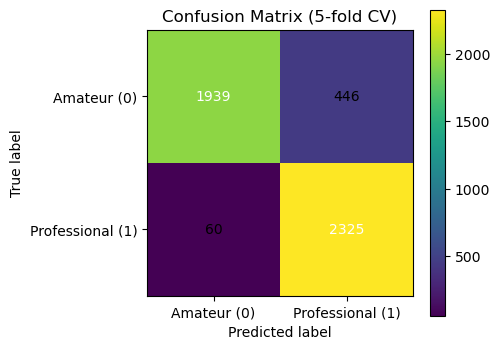

In [10]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(5,4))                                            # set figure size
im = ax.imshow(cm, interpolation='nearest')                                      # show matrix as image (default colormap)
ax.set_title("Confusion Matrix (5-fold CV)")                                     # title
plt.colorbar(im, ax=ax)                                                          # color bar

# Configure tick labels
tick_marks = np.arange(2)                                                        # ticks 0 and 1
ax.set_xticks(tick_marks)                                                        # set x ticks
ax.set_yticks(tick_marks)                                                        # set y ticks
ax.set_xticklabels(["Amateur (0)", "Professional (1)"])                          # x tick labels
ax.set_yticklabels(["Amateur (0)", "Professional (1)"])                          # y tick labels

# Annotate counts in each cell
thresh = cm.max() / 2.0                                                          # threshold for text color
for i in range(cm.shape[0]):                                                     # iterate rows
    for j in range(cm.shape[1]):                                                 # iterate cols
        ax.text(j, i, format(cm[i, j], 'd'),                                     # write integer count
                ha="center", va="center",                                        # centered text
                color="white" if cm[i, j] > thresh else "black")                 # contrast text color

# Axis labels and layout
ax.set_ylabel('True label')                                                      # y-axis label
ax.set_xlabel('Predicted label')                                                 # x-axis label
plt.tight_layout()                                                               # nicer layout
plt.show()                                                                       # render plot


Step 7 - Plot Accuracy and Loss Plots

History keys detected -> acc_key: accuracy | val_acc_key: val_accuracy | loss_key: loss | val_loss_key: val_loss


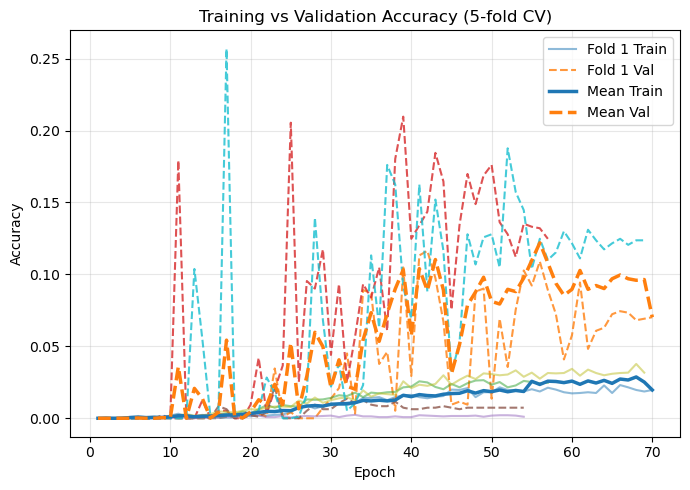

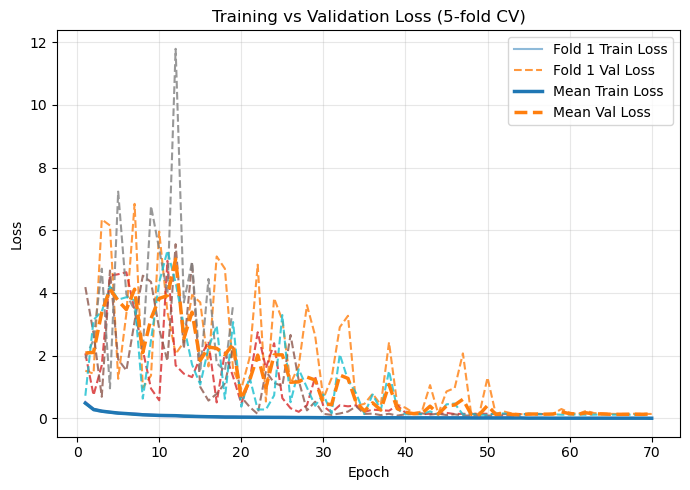

In [11]:
def get_key(d, *candidates):
    """Return the first key present in dict d from the candidate list (handles TF naming differences)."""
    for k in candidates:                                                         # loop through candidate keys
        if k in d:                                                               # if key exists
            return k                                                             # return it
    return None                                                                  # if none match

# Detect metric keys from the first history dict (can differ by TF/Keras version)
acc_key      = get_key(histories[0], 'accuracy', 'acc')                          # training accuracy key
val_acc_key  = get_key(histories[0], 'val_accuracy', 'val_acc')                  # validation accuracy key
loss_key     = 'loss'                                                             # training loss key
val_loss_key = 'val_loss'                                                         # validation loss key

print("History keys detected ->",
      "acc_key:", acc_key, "| val_acc_key:", val_acc_key,
      "| loss_key:", loss_key, "| val_loss_key:", val_loss_key)                  # show detected keys

# ----- Plot Accuracy -----
plt.figure(figsize=(7,5))                                                         # figure for accuracy
max_len = max(len(h[acc_key]) for h in histories)                                 # longest training run among folds
xs = np.arange(1, max_len+1)                                                      # x-axis epochs for mean curves

acc_curves, val_acc_curves = [], []                                               # store padded curves

for i, h in enumerate(histories, start=1):                                        # loop folds
    a  = np.array(h[acc_key], dtype=float)                                        # train accuracy per epoch
    va = np.array(h[val_acc_key], dtype=float)                                    # val accuracy per epoch

    # pad with NaNs to align curve lengths for mean computation
    acc_curves.append(np.pad(a,  (0, max_len - len(a)),  constant_values=np.nan)) # pad train acc
    val_acc_curves.append(np.pad(va, (0, max_len - len(va)), constant_values=np.nan)) # pad val acc

    # plot each fold's curves
    plt.plot(np.arange(1, len(a)+1),  a,  alpha=0.5, label=f"Fold {i} Train" if i==1 else None) # fold train
    plt.plot(np.arange(1, len(va)+1), va, alpha=0.8, linestyle='--', label=f"Fold {i} Val" if i==1 else None) # fold val

# compute mean curves across folds, ignoring NaNs (due to different early stopping epochs)
mean_acc = np.nanmean(np.vstack(acc_curves), axis=0)                              # mean train acc
mean_val_acc = np.nanmean(np.vstack(val_acc_curves), axis=0)                      # mean val acc

# overlay mean curves
plt.plot(xs, mean_acc, linewidth=2.5, label="Mean Train")                         # mean train curve
plt.plot(xs, mean_val_acc, linewidth=2.5, linestyle='--', label="Mean Val")       # mean val curve

# finish plot formatting
plt.title("Training vs Validation Accuracy (5-fold CV)")                          # title
plt.xlabel("Epoch")                                                                # x label
plt.ylabel("Accuracy")                                                             # y label
plt.legend()                                                                       # legend
plt.grid(True, alpha=0.3)                                                          # light grid
plt.tight_layout()                                                                 # layout
plt.show()                                                                         # render plot

# ----- Plot Loss -----
plt.figure(figsize=(7,5))                                                         # figure for loss
max_len = max(len(h[loss_key]) for h in histories)                                # longest run
xs = np.arange(1, max_len+1)                                                      # x-axis epochs

loss_curves, val_loss_curves = [], []                                             # store padded curves

for i, h in enumerate(histories, start=1):                                        # loop folds
    l  = np.array(h[loss_key], dtype=float)                                       # train loss per epoch
    vl = np.array(h[val_loss_key], dtype=float)                                   # val loss per epoch

    # pad with NaNs for alignment
    loss_curves.append(np.pad(l,  (0, max_len - len(l)),  constant_values=np.nan))    # pad train loss
    val_loss_curves.append(np.pad(vl, (0, max_len - len(vl)), constant_values=np.nan)) # pad val loss

    # plot each fold's curves
    plt.plot(np.arange(1, len(l)+1),  l,  alpha=0.5, label=f"Fold {i} Train Loss" if i==1 else None) # train loss
    plt.plot(np.arange(1, len(vl)+1), vl, alpha=0.8, linestyle='--', label=f"Fold {i} Val Loss" if i==1 else None) # val loss

# compute mean curves across folds
mean_loss = np.nanmean(np.vstack(loss_curves), axis=0)                            # mean train loss
mean_val_loss = np.nanmean(np.vstack(val_loss_curves), axis=0)                    # mean val loss

# overlay mean curves
plt.plot(xs, mean_loss, linewidth=2.5, label="Mean Train Loss")                   # mean train loss curve
plt.plot(xs, mean_val_loss, linewidth=2.5, linestyle='--', label="Mean Val Loss") # mean val loss curve

# finish plot formatting
plt.title("Training vs Validation Loss (5-fold CV)")                              # title
plt.xlabel("Epoch")                                                                # x label
plt.ylabel("Loss")                                                                 # y label
plt.legend()                                                                       # legend
plt.grid(True, alpha=0.3)                                                          # light grid
plt.tight_layout()                                                                 # layout
plt.show()                                                                         # render plot
